# Flights Data Exploration
## by Daiki Kudo

## Preliminary Wrangling

> This document explores a dataset containing approximately 7 million records of flight data in 2008.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import timeit
import glob
pd.set_option('display.max_columns', 500)

%matplotlib inline

In [2]:
# load in the dataset into pandas dataframe
df_2008 = pd.read_csv("2008.csv", dtype={'DepTime':str, "CRSDepTime":str, "ArrTime":str, "CRSArrTime":str})

In [3]:
df=df_2008.copy()
df.head(3)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003,1955,2211,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754,735,1002,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628,620,804,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
Year                 7009728 non-null int64
Month                7009728 non-null int64
DayofMonth           7009728 non-null int64
DayOfWeek            7009728 non-null int64
DepTime              6873482 non-null object
CRSDepTime           7009728 non-null object
ArrTime              6858079 non-null object
CRSArrTime           7009728 non-null object
UniqueCarrier        7009728 non-null object
FlightNum            7009728 non-null int64
TailNum              6926363 non-null object
ActualElapsedTime    6855029 non-null float64
CRSElapsedTime       7008884 non-null float64
AirTime              6855029 non-null float64
ArrDelay             6855029 non-null float64
DepDelay             6873482 non-null float64
Origin               7009728 non-null object
Dest                 7009728 non-null object
Distance             7009728 non-null int64
TaxiIn               6858079 non-

> Ther are some points I have to take care in this data.
* Duplicsted rows should be deleted.
* In this analysis, I will focus only on delay, so flight records which are cancelled or diverted should be removed.(Many of these rows have null values in some "Time" columns)
* It would be more convinient if there is a column "delay_elapsed" which is a delay time calculated from "ActualElapsedTime" - "CRSElapsedTime". 
* NaN in "CarrierDelay","WeatherDelay","NASDelay","SecurityDelay","LateAircraftDelay" shoud be replaced with 0.

In [5]:
# delete duplicsted rows  
print(df.duplicated().sum())
df = df.drop_duplicates()

4


In [6]:
# remove rows which are cancelled or diverted, and remove unnecessary columns.
print(df["Cancelled"].value_counts())
print(df["Diverted"].value_counts())
assert df[(df.Cancelled ==1) & (df.Diverted ==1)].shape[0] == 0

df = df[(df.Cancelled==0) & (df.Diverted==0)]
print(df.Cancelled.value_counts())
print(df.Diverted.value_counts())
df = df.drop(columns=["Cancelled","Diverted","CancellationCode"])

0    6872290
1     137434
Name: Cancelled, dtype: int64
0    6992459
1      17265
Name: Diverted, dtype: int64
0    6855025
Name: Cancelled, dtype: int64
0    6855025
Name: Diverted, dtype: int64


In [7]:
#  add a column "delay_elapsed"

df["delay_elapsed"] = df.ActualElapsedTime - df.CRSElapsedTime
df.head(1)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
0,2008,1,3,4,2003,1955,2211,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,NaN,NaN,NaN,NaN,NaN,-22.0


In [8]:
# confiem that ArrDelay = DepDelay + delay_elapsed (allowing erros within 3 minutes)

assert df[(df.ArrDelay - df.DepDelay - df.delay_elapsed < -3) + (df.ArrDelay - df.DepDelay - df.delay_elapsed > 3) != 0].shape[0] == 0

/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [9]:
# replace NaN with 0. in "CarrierDelay","WeatherDelay","NASDelay","SecurityDelay","LateAircraftDelay"

df = df.fillna(value = {"CarrierDelay":0,"WeatherDelay":0,"NASDelay":0,"SecurityDelay":0.,"LateAircraftDelay":0})
df.sample(5)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
441566,2008,1,5,6,613,622,746,806,NW,1003,N760NW,93.0,104.0,65.0,-20.0,-9.0,SYR,DTW,374,12.0,16.0,0.0,0.0,0.0,0.0,0.0,-11.0
5822084,2008,10,4,6,1930,1935,2036,2045,9E,5904,89409E,66.0,70.0,42.0,-9.0,-5.0,MEM,MGM,280,4.0,20.0,0.0,0.0,0.0,0.0,0.0,-4.0
2250816,2008,4,21,1,1851,1855,2107,2024,9E,5650,85879E,136.0,89.0,105.0,43.0,-4.0,BIS,MSP,386,9.0,22.0,0.0,0.0,43.0,0.0,0.0,47.0
127653,2008,1,31,4,1623,1532,1749,1617,XE,2861,N14516,86.0,45.0,28.0,92.0,51.0,IAH,LCH,127,6.0,52.0,51.0,0.0,41.0,0.0,0.0,41.0
26199,2008,1,11,5,1325,1325,1411,1415,WN,112,N511SW,46.0,50.0,32.0,-4.0,0.0,DAL,AUS,189,3.0,11.0,0.0,0.0,0.0,0.0,0.0,-4.0


In [10]:
# descriptive statistics for numeric variables
df.describe()

,Year,Month,DayofMonth,DayOfWeek,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
count,6855025.0,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06
mean,2008.0,6.388527e+00,1.573825e+01,3.925802e+00,2.212508e+03,1.273224e+02,1.290778e+02,1.040186e+02,8.168445e+00,9.923839e+00,7.287436e+02,6.860149e+00,1.644369e+01,3.508109e+00,6.759592e-01,3.817850e+00,1.667623e-02,4.620004e+00,-1.755392e+00
std,0.0,3.398832e+00,8.801084e+00,1.988460e+00,1.956437e+03,7.018731e+01,6.953271e+01,6.743979e+01,3.850194e+01,3.520387e+01,5.632447e+02,4.931225e+00,1.131062e+01,2.001675e+01,9.284378e+00,1.665013e+01,8.673705e-01,2.043151e+01,1.403088e+01
min,2008.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.200000e+01,-1.410000e+02,0.000000e+00,-5.190000e+02,-5.340000e+02,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.810000e+02
25%,2008.0,3.000000e+00,8.000000e+00,2.000000e+00,6.180000e+02,7.700000e+01,8.000000e+01,5.500000e+01,-1.000000e+01,-4.000000e+00,3.260000e+02,4.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e+00
50%,2008.0,6.000000e+00,1.600000e+01,4.000000e+00,1.563000e+03,1.100000e+02,1.110000e+02,8.600000e+01,-2.000000e+00,-1.000000e+00,5.810000e+02,6.000000e+00,1.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.000000e+00
75%,2008.0,9.000000e+00,2.300000e+01,6.000000e+00,3.494000e+03,1.570000e+02,1.590000e+02,1.320000e+02,1.200000e+01,8.000000e+00,9.540000e+02,8.000000e+00,1.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
max,2008.0,1.200000e+01,3.100000e+01,7.000000e+00,9.741000e+03,1.379000e+03,6.600000e+02,1.350000e+03,2.461000e+03,2.467000e+03,4.962000e+03,3.080000e+02,4.290000e+02,2.436000e+03,1.352000e+03,1.357000e+03,3.920000e+02,1.316000e+03,1.034000e+03


### What is the structure of your dataset?

> Now, there are  rows of flight data in the dataset with 29 features originally.  
> Variable descriptions 
>  
Name	Description
>  
1	Year	2008  
2	Month	1-12  
3	DayofMonth	1-31  
4	DayOfWeek	1 (Monday) - 7 (Sunday)  
>  
5	DepTime	        actual departure time (local, hhmm)   
6	CRSDepTime	    scheduled departure time (local, hhmm)  
7	ArrTime	actual  arrival time (local, hhmm)    
8	CRSArrTime	    scheduled arrival time (local, hhmm)  
>  
9	UniqueCarrier	unique carrier code  
10	FlightNum	    flight number  
11	TailNum	        plane tail number  
>  
12	ActualElapsedTime	(actual)    in minutes  
13	CRSElapsedTime      (scheduled)	in minutes  
14	AirTime	in minutes 
>  
15	ArrDelay	(Difference in minutes between scheduled and actual arrival time)   
16	DepDelay	(Difference in minutes between scheduled and actual departure time. )    
>  
17	Origin	origin IATA airport code    
18	Dest	destination IATA airport code   
(Code assigned by IATA and commonly used to identify a carrier. As the same code may have been assigned to different carriers over time, the code is not always unique.)
>  
19	Distance	in miles 
>  
20	TaxiIn	taxi in time, in minutes  
21	TaxiOut	taxi out time, in minutes  
>  
22	CarrierDelay        in minutes  
23	WeatherDelay	    in minutes  
24	NASDelay	        (National Air System Delay) in minutes  
25	SecurityDelay	    in minutes  
26	LateAircraftDelay	in minutes  
>
> More details can be found [here](http://aspmhelp.faa.gov/index.php/Types_of_Delay)
* Carrier Delay  
Carrier delay is within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays.
* Late Arrival Delay  
Arrival delay at an airport due to the late arrival of the same aircraft at a previous airport. The ripple effect of an earlier delay at downstream airports is referred to as delay propagation.
* NAS Delay  
Delay that is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc. Delays that occur after Actual Gate Out are usually attributed to the NAS and are also reported through OPSNET.
* Security Delay  
Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.
* Weather Delay  
Weather delay is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival.

### What is/are the main feature(s) of interest in your dataset?

>  
* What causes the longer delays?

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?
 
> * 2 factors of delay (***departure delay + elapsed time extension***)
 - arrival delay = ArrDelay = ArrTime - CRSArrTime
 - departure delay = DepDelay = DepTime - CRSDepTime
 - elapsed time extension = ActualElapsedTime - CRSElapsedTime  
> * Distance 
> * 5 delay factors given in the dataset  
 - WeatherDelay, NAS Delay, SecurityDelay, LateAircraftDelay  

## Univariate Exploration

> In this section, I start by looking at the distrbution of main variables.  
1. Disatance  
- AirTime
- ArrDelay
- DepDelay
- delay_elapsed

### Distance

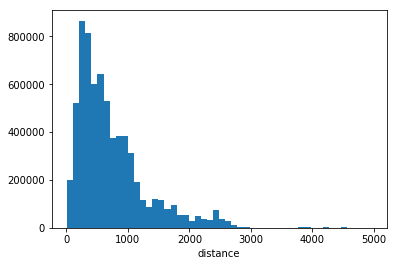

In [11]:
plt.hist(data = df, x = "Distance", bins = 50)
plt.xlabel("distance");

In [12]:
# The extremely high values on the left of most bins should be paid more attention. These can be outliers.
df[ df.Distance > 3500].sample(5)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
590757,2008,1,3,4,1854,1900,822,844,DL,850,N833MH,508.0,524.0,487.0,-22.0,-6.0,HNL,ATL,4502,6.0,15.0,0.0,0.0,0.0,0.0,0.0,-16.0
1397290,2008,3,29,6,1608,1610,448,504,UA,2,N215UA,460.0,474.0,439.0,-16.0,-2.0,HNL,ORD,4243,5.0,16.0,0.0,0.0,0.0,0.0,0.0,-14.0
5270882,2008,9,2,2,1649,1655,446,505,AA,6,N347AA,417.0,430.0,406.0,-19.0,-6.0,OGG,DFW,3711,3.0,8.0,0.0,0.0,0.0,0.0,0.0,-13.0
6988164,2008,12,8,1,1953,2000,736,730,CO,2,N76064,463.0,450.0,432.0,6.0,-7.0,HNL,IAH,3904,11.0,20.0,0.0,0.0,0.0,0.0,0.0,13.0
6684795,2008,12,28,7,1748,1800,518,552,UA,1003,N213UA,450.0,472.0,436.0,-34.0,-12.0,KOA,ORD,4213,5.0,9.0,0.0,0.0,0.0,0.0,0.0,-22.0


In [13]:
# It seems like they are flight from or to Hawaii.  Confirm all the high values applies to them.
hawaii = ["HNL", "OGG", "KOA"]
assert df[(df.Distance > 3500) + (~df.Origin.isin(hawaii)) + (~df.Dest.isin(hawaii)) == 3].shape[0] == 0

/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


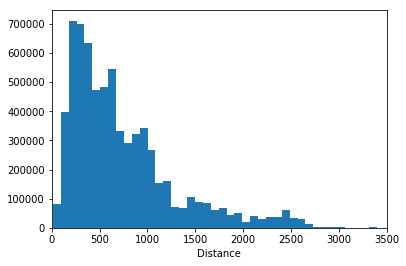

In [14]:
# take a closer look at the data in the x-range bwtween 0 and 3500.
# set x-limit betweeen 0 and 3500
plt.hist(data=df, x="Distance", bins=60)
plt.xlabel("Distance")
plt.xlim([0,3500]);

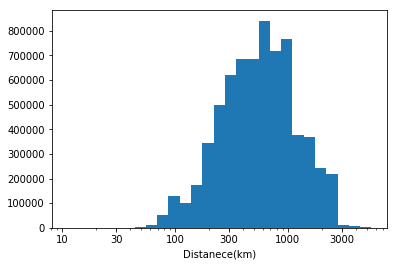

In [15]:
# There is a long tail in the distribution, so put it on a log scale instead.

bin = 10 ** np.arange(np.log10(df.Distance.min()), np.log10(df.Distance.max())+0.1, 0.1)
plt.hist(data=df, x="Distance", bins=bin)
plt.xscale("log")
plt.xlabel("Distanece(km)")
plt.xticks([10,30,100,300,1000,3000],[10,30,100,300,1000,3000]);

> Distance has a long-tailed distribution, with a lot of flights on the short distance end, and a few on the long distance end. When plotted on a log-scale, the distance distribution looks roughly normal distribution with a distance ceilings at the left foot. This is simply because the longer the distance between airports is, the more limited flights there are. And some highest values are, as I saw, the flight from or to Hawaii.

### AirTime

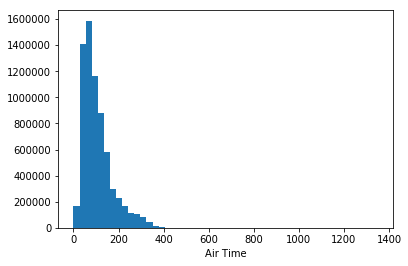

In [16]:
plt.hist(data = df, x = "AirTime", bins = 50)
plt.xlabel("Air Time");

In [17]:
# make sure that they are from the flight data which is from or to Hawaii
assert df[(df.AirTime > 500) + (~df.Origin.isin(hawaii)) + (~df.Dest.isin(hawaii)) == 3 ].shape[0] == 0

/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


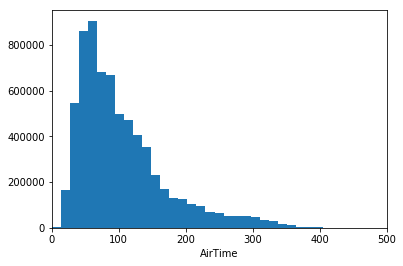

In [18]:
# Now take a closer look at the airtime distribution.
plt.hist(data = df, x = "AirTime", bins = 100)
plt.xlim([0,500])
plt.xlabel("AirTime");

> When I tried to make a log scale plot, I had ValueError and it made me realize that some of AirTime values are 0 and that I couldn't take the logarithm. I looked at these values and couldn't understand why these 0 values existed. ***This AirTime should have many things to do with Distance so I would investigate it later using bivariate visualization part.*** But now, I will remove only rows whose AirTime sre 0 to make a log plot.

In [19]:
# remove rows whose AirTime is 0.
df[df.AirTime != 0].shape[0]
df = df[df.AirTime != 0]

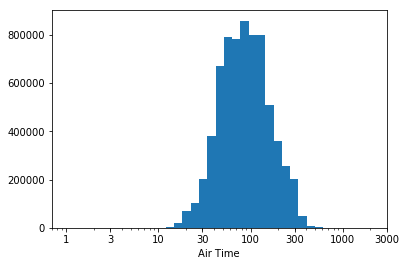

In [20]:
# There is a long left tail in the distribution, put it on a log scale instead.

bin = 10 ** np.arange(np.log10(df.AirTime.min()), np.log10(df.AirTime.max())+0.09, 0.09)
plt.hist(data=df, x="AirTime", bins=bin)
plt.xscale("log")
plt.xticks([1,3,10,30,100,300,1000,3000],[1,3,10,30,100,300,1000,3000])
plt.xlabel("Air Time");

> AirTime is left-skewed and the shape of distribution is similar to that of distance. When I tried to make a log scale plot on x-axis, I found that some values are equal to 0. I removed these rows, but I still have to check these values by comparing with Distance.

### ArrDelay

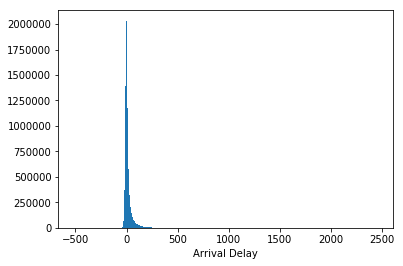

In [21]:
plt.hist(data=df, x="ArrDelay", bins=np.arange(df.ArrDelay.min(),df.ArrDelay.max()+10,10) )
plt.xlabel("Arrival Delay");

In [22]:
## The extremely high and wxtremely low values should be paid more attention. These can be outliers.
#     rows with low ArrDelay values 
df[(df.ArrDelay < -120) ]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
2486419,2008,5,8,4,1250,1300,1412,1621,XE,312,N14558,22.0,141.0,7.0,-129.0,-10.0,AUS,JAX,954,5.0,10.0,0.0,0.0,0.0,0.0,0.0,-119.0
5179806,2008,9,29,1,136,1030,456,1335,HA,7,N587HA,380.0,365.0,355.0,-519.0,-534.0,LAS,HNL,2762,5.0,20.0,0.0,0.0,0.0,0.0,0.0,15.0


In [23]:
#     rows with high ArrDelay values 
df[(df.ArrDelay > 2400) ]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
1018798,2008,2,3,7,1117,1820,2256,555,NW,808,N817NW,459.0,455.0,437.0,2461.0,2457.0,HNL,MSP,3972,6.0,16.0,1455.0,0.0,4.0,0.0,1002.0,4.0
2235378,2008,4,10,4,724,1417,858,1605,NW,1699,N3324L,154.0,168.0,132.0,2453.0,2467.0,CLT,MSP,930,8.0,14.0,2436.0,0.0,0.0,0.0,17.0,-14.0


> Even though these rows don't seem to have human errors, these arrival delays (more than 40 hours) are quite unnatural.    
I will break this arrival delay into 2 portions (DepDelay and delay_elapesd) and deal with them later.

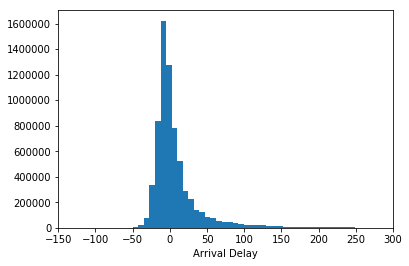

In [24]:
# take a closer look at the data ArrDelay
plt.hist(data=df, x="ArrDelay", bins=400)
plt.xlabel("Arrival Delay")
plt.xlim([-150,300]);

The distribution is a little left-skewed and the mode is around 0 minutes. I have never experienced the flight which arrived earlier than scheduled, so it was surprising for me that many flight actually arrives ahead. Whether it is attributed to the earlier departure or to shorter flight time would be revealed from now.

### DepDelay

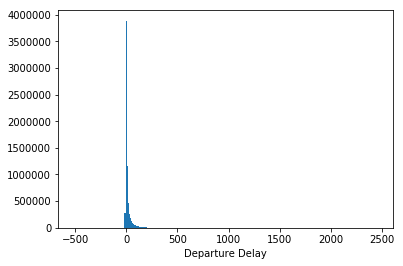

In [25]:
plt.hist(data=df, x="DepDelay",bins=np.arange(df.ArrDelay.min(),df.ArrDelay.max()+10,10))
plt.xlabel("Departure Delay");

In [26]:
df[df.DepDelay < -120]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
5179806,2008,9,29,1,136,1030,456,1335,HA,7,N587HA,380.0,365.0,355.0,-519.0,-534.0,LAS,HNL,2762,5.0,20.0,0.0,0.0,0.0,0.0,0.0,15.0


In [27]:
df[df.DepDelay > 2400]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
1018798,2008,2,3,7,1117,1820,2256,555,NW,808,N817NW,459.0,455.0,437.0,2461.0,2457.0,HNL,MSP,3972,6.0,16.0,1455.0,0.0,4.0,0.0,1002.0,4.0
2235378,2008,4,10,4,724,1417,858,1605,NW,1699,N3324L,154.0,168.0,132.0,2453.0,2467.0,CLT,MSP,930,8.0,14.0,2436.0,0.0,0.0,0.0,17.0,-14.0


> I investigated outliers for a while and decided to remove only 1 row which showed -534 minutes departure delay between Las Vegas and Hawaii, which rarely happens.  
Even though delays more than 1 day are unusual, the reasons of them are explained and so I will leave them.

In [28]:
#  remove rows with outliers in DepDelay column.
df = df[(df.DepDelay > -120)]

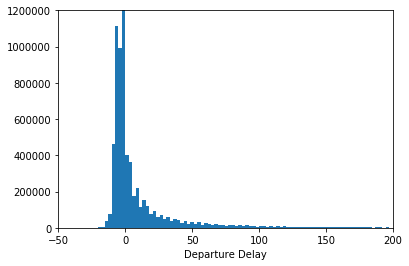

In [29]:
# plot the histgram again in the limit of [-50<x<200]
plt.hist(data=df, x="DepDelay",bins=1000)
plt.xlabel("Departure Delay")
plt.xlim([-50,200])
plt.ylim([0,1200000]);

> The distribution of the delay of departure time is left-skewed and the mode is around 0 minutes, which makes sense.

### Delay_Elapsed

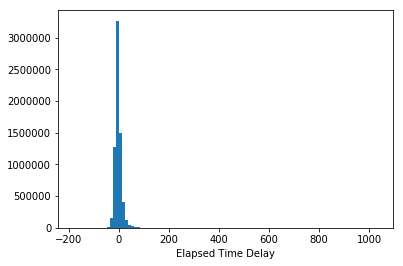

In [30]:
plt.hist(data=df, x="delay_elapsed", bins = 100)
plt.xlabel("Elapsed Time Delay");

In [31]:
df[df.delay_elapsed < -100]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
682725,2008,2,26,2,2116,1940,2130,2135,WN,1830,N747SA,134.0,235.0,125.0,-5.0,96.0,MCI,SMF,1442,4.0,5.0,0.0,0.0,0.0,0.0,0.0,-101.0
1637767,2008,3,9,7,1823,1420,2051,1910,9E,2029,91469E,148.0,290.0,90.0,101.0,243.0,PIT,ATL,526,32.0,26.0,0.0,0.0,0.0,0.0,101.0,-142.0
1705852,2008,3,8,6,1256,1135,1627,1737,AA,2093,N3CDAA,211.0,362.0,177.0,1370.0,1521.0,LGA,MIA,1097,5.0,29.0,50.0,0.0,1289.0,0.0,31.0,-151.0
2486419,2008,5,8,4,1250,1300,1412,1621,XE,312,N14558,22.0,141.0,7.0,-129.0,-10.0,AUS,JAX,954,5.0,10.0,0.0,0.0,0.0,0.0,0.0,-119.0
2558089,2008,5,1,4,1302,929,1427,1355,OO,6595,N924SW,85.0,266.0,70.0,32.0,213.0,SLC,DEN,391,6.0,9.0,32.0,0.0,0.0,0.0,0.0,-181.0
3092993,2008,6,15,7,1244,940,1519,1420,XE,408,N12563,95.0,220.0,84.0,59.0,184.0,SAN,ABQ,628,5.0,6.0,59.0,0.0,0.0,0.0,0.0,-125.0
3698229,2008,7,31,4,1449,1430,1331,1520,WN,987,N396SW,42.0,170.0,29.0,-109.0,19.0,AUS,SAN,1164,3.0,10.0,0.0,0.0,0.0,0.0,0.0,-128.0


In [32]:
df[df.delay_elapsed > 360]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
1556682,2008,3,6,4,906,905,2103,1315,HA,7,N585HA,837.0,370.0,823.0,468.0,1.0,LAS,HNL,2762,5.0,9.0,468.0,0.0,0.0,0.0,0.0,467.0
2160490,2008,4,27,7,1343,1340,748,2215,HA,22,N587HA,905.0,335.0,886.0,573.0,3.0,HNL,SEA,2677,9.0,10.0,573.0,0.0,0.0,0.0,0.0,570.0
2763487,2008,5,24,6,920,920,519,1205,HA,21,N580HA,1379.0,345.0,1350.0,1034.0,0.0,SEA,HNL,2677,16.0,13.0,1034.0,0.0,0.0,0.0,0.0,1034.0
2763567,2008,5,11,7,1228,1230,811,2105,HA,28,N583HA,1003.0,335.0,981.0,666.0,-2.0,HNL,SEA,2677,4.0,18.0,648.0,0.0,0.0,0.0,18.0,668.0
2763603,2008,5,16,5,1021,1035,303,1320,HA,29,N592HA,1182.0,345.0,1154.0,823.0,-14.0,SEA,OGG,2640,5.0,23.0,823.0,0.0,0.0,0.0,0.0,837.0
3900816,2008,7,23,3,1559,1605,20,1825,US,598,N657AW,681.0,320.0,279.0,355.0,-6.0,PHL,LAS,2176,9.0,393.0,0.0,0.0,355.0,0.0,0.0,361.0
3922427,2008,7,23,3,1727,1645,323,2033,DL,151,N6700,776.0,408.0,346.0,410.0,42.0,JFK,SFO,2586,8.0,422.0,0.0,0.0,368.0,0.0,42.0,368.0
3993887,2008,7,16,3,228,230,1250,520,HA,17,N586HA,802.0,350.0,757.0,450.0,-2.0,LAS,HNL,2762,23.0,22.0,450.0,0.0,0.0,0.0,0.0,452.0
4614554,2008,8,19,2,1547,1230,717,2105,HA,28,N597HA,750.0,335.0,733.0,612.0,197.0,HNL,SEA,2677,4.0,13.0,612.0,0.0,0.0,0.0,0.0,415.0
5180146,2008,9,9,2,1411,920,545,1215,HA,21,N586HA,1114.0,355.0,1091.0,1050.0,291.0,SEA,HNL,2677,5.0,18.0,1040.0,0.0,0.0,0.0,10.0,759.0


> I investigated the data and decided to remove 2 rows whose indecies are 2486419 or 3698229 (both in the first cell).  
I made this decision by comparing AirTime and ActualElapsedTime. These 2 rows had extremely short AirTimes considering Distances.  
Regarding rest of them, there seems like no reason to be deleted.

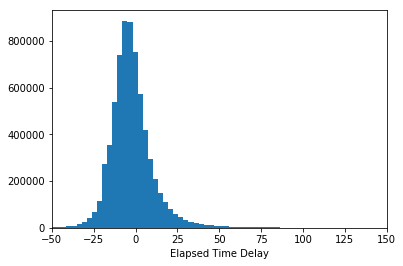

In [33]:
# plot the histgram again in the limit of [-50<x<200]
plt.hist(data=df, x="delay_elapsed",bins=400)
plt.xlabel("Elapsed Time Delay")
plt.xlim([-50,150]);

> Though departure delay was left skewed, the elapsed time delay is symmetric. The mode is less than 0 minutes and it can be assumed that in-flight time is a little longer estimated.
>
> The distributions of Departure delay and Elapsed time delay accout for the arrival delay. The earlier arrival are more associated with shorter flight time, and the late arrival delays may be rather due to lengthy departure delay.

### Each of 5 Delay Factors

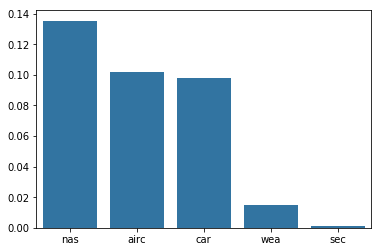

In [34]:
# The proportion where each type of delay occurs.
p_car = df[df.CarrierDelay != 0].shape[0] / df.shape[0]
p_wea = df[df.WeatherDelay != 0].shape[0] / df.shape[0]
p_nas = df[df.NASDelay != 0].shape[0] / df.shape[0]
p_sec = df[df.SecurityDelay != 0].shape[0] / df.shape[0]
p_airc = df[df.LateAircraftDelay != 0].shape[0] / df.shape[0]

delay_types = pd.Series([p_car,p_wea,p_nas,p_sec,p_airc], index=["car","wea","nas","sec","airc"]).sort_values(ascending=False)
sb.barplot(delay_types.index, delay_types, color=sb.color_palette()[0]);

> This is the probability that each type of delay occured in 2008. (2 types of delay can simultaneously happen at the same flight!!!)  
This plot suggests that delay caused by National Airspace System (NAS) more frequently happens and surprisingly for me, delay due to bad weather or security check which I personally have thought is the main reason I can be stuck in the airport happens less frequently.

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


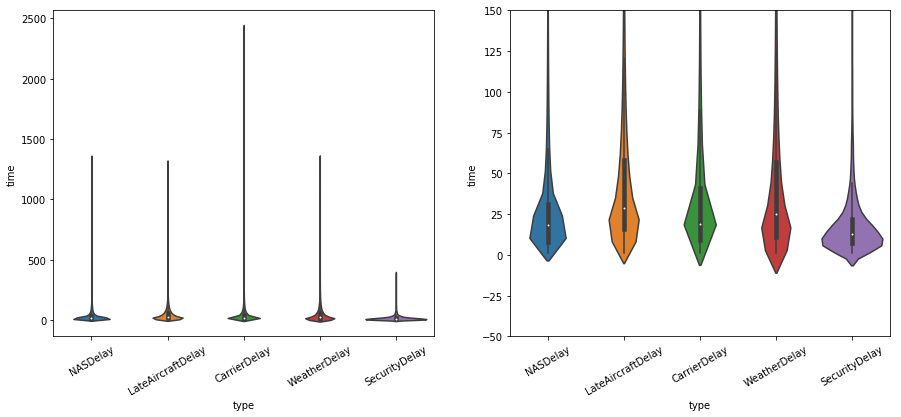

In [35]:
# take a look at the distribution on how many minutes each delay factor can prolong the flight time

## make dummy series which has 2 columns, delay type and delay time
dummy = pd.DataFrame()
delay_types = ["NASDelay","LateAircraftDelay","CarrierDelay","WeatherDelay","SecurityDelay"]

for type in delay_types:
    dum = pd.DataFrame()
    dum["time"] = df[df[type] != 0][type]
    dum["type"] = type
    dummy = dummy.append(dum)

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
sb.violinplot(data= dummy, x="type", y="time")
plt.xticks(rotation=30);
plt.subplot(1,2,2)
sb.violinplot(data= dummy, x="type", y="time")
plt.ylim([-50,150])
plt.xticks(rotation=30);

> These distribution plots suggest that LateAirCraftDelay and WeatherDelay tend to take longer rather than NASDelay and CarrierDelay. Regarding SecurityDelay, since the length of time is shorter and also the frequency it happens is by far the least of the 5, the effect can be thought to be quite weaker than other 4 factors. From now on, ***I will investigate only 4 effects of "NASDelay", "LateAircraftDelay", "CarrierDelay", "WeatherDelay".***

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> 
>  
The distribution arrival delay was a little left-skewed and the mode is around 0 minute. It revealed that many flight actually arrives ahead of scheduled time. This could be investigated further by breaking down into 2 portions, Departure delay and Elapsed time delay. 
>  
   - The distribution of the Departure delay was left-skewed and the mode was around 0 minute.   
   - Elapsed time delay was symmetric and the mode was less than 0 minute.   

>     
I could assume that earlier arrival is more associated with shorter flight time, and the late arrival delays may be rather due to lengthy departure delay. I could not perform log transformation though they were skewed, because the range of these variables involved negative values. 
>
>
>
> I also visualized the property of 5 delay factors. The plot suggested that delay caused by National Airspace System (NAS) happened most frequently followed by LateAircraftDelay, CarrierDelay and WeatherDelay. Regarding the length of delay time, LateAirCraftDelay and WeatherDelay tend to take longer than NASDelay and CarrierDelay.   
>  
The effect of SecurityDelay was thought to be quite weaker than other 4 factors, so I decided to investigateonly only 4 delay factors from now on.


### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> When investigating Distance, I found the data which showed extremely ling distancesmore than 3500km. I found that these records are the flight which are from or to Hawaiian airport, so I left them.  
>
> Though I removed 1 row which had extremely long AirTime just for safety, this dataset seems to be quite reliable.  

## Bivariate Exploration

> To start off with, I want to look at the pairwise correlations present between featires in the data.  

In [36]:
df2 = df.copy()
numeric_vars = ["ArrDelay","delay_elapsed","DepDelay","Distance","AirTime","CarrierDelay","WeatherDelay","NASDelay","LateAircraftDelay"]
categoric_var = []

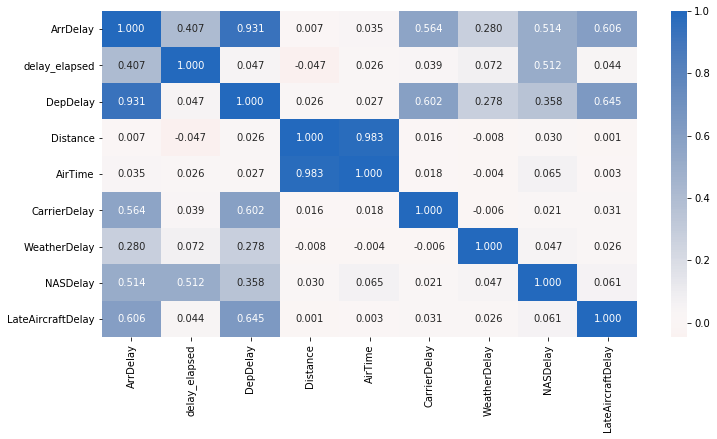

In [37]:
# correlation plot
plt.figure(figsize=[12,6])
sb.heatmap(df[numeric_vars].corr(), annot=True, fmt=".3f", cmap="vlag_r", center=0);

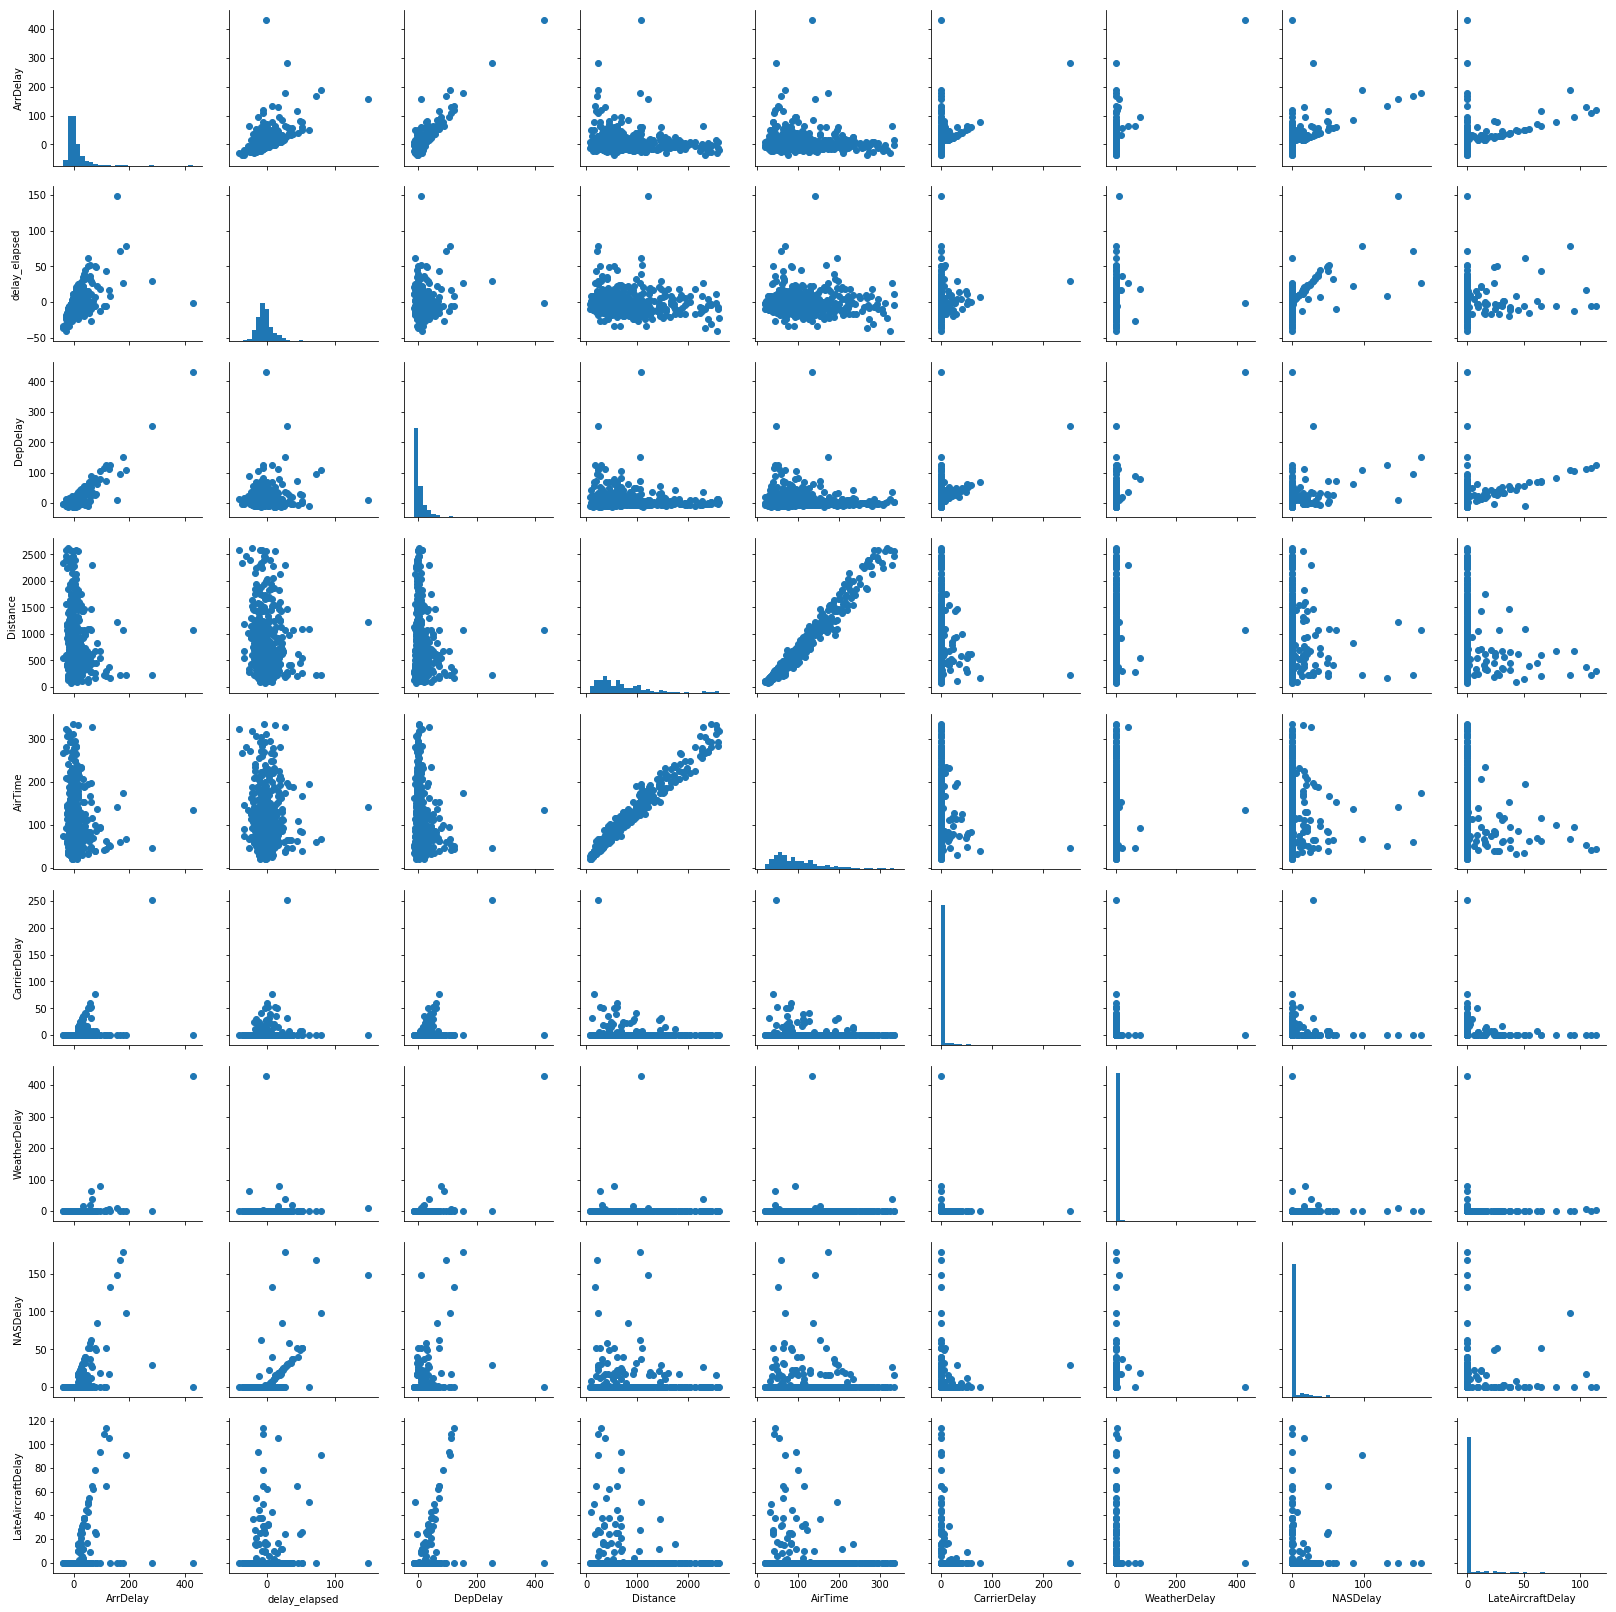

In [38]:
# plot matrix : sample 1000 flight data so that plots are clearer and they render faster
samples = np.random.choice(df2.shape[0], 500, replace=False)
df2_sample = df2.iloc[samples,:]

g = sb.PairGrid(data=df2_sample, vars=numeric_vars)
g = g.map_diag(plt.hist, bins = 30);
g.map_offdiag(plt.scatter);

### Distance vs. AirTime

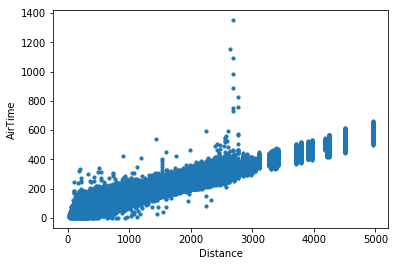

In [39]:
plt.scatter(data=df2, x="Distance", y="AirTime", alpha=1, s=10)
plt.xlabel("Distance") 
plt.ylabel("AirTime");

>  
Further
1. AirTime around 0 but Distance != 0
-  extremely long AirTime at Distance around 2800

> 1. AirTime around 0 but Distance != 0

In [40]:
df2[df2.Distance == df2.Distance.min()]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
2547298,2008,5,15,4,2037,1800,2125,1900,OH,4988,N806CA,48.0,60.0,31.0,145.0,157.0,JFK,LGA,11,10.0,7.0,145.0,0.0,0.0,0.0,0.0,-12.0
4392215,2008,8,10,7,1315,1220,1415,1320,OH,5572,N819CA,60.0,60.0,14.0,55.0,55.0,JFK,LGA,11,8.0,38.0,55.0,0.0,0.0,0.0,0.0,0.0


> It is surprising for me but, there actually exists the flight between JFK and LGA.  
This is the shortest flight, so the fllights which takes less than 31.0 minutes are impossible, so I will delete them.  
There still can be some wrong data, but I don't go further on them.

In [41]:
#delete these outliers
print(df2[df2.AirTime < 31.0].shape[0])
df2 = df2[df2.AirTime > 31.0]

288362


> 2. extremely long AirTime at Distance around 2800

In [42]:
df2[(df2.Distance<3000) & (df2.AirTime>600)]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
1556682,2008,3,6,4,906,905,2103,1315,HA,7,N585HA,837.0,370.0,823.0,468.0,1.0,LAS,HNL,2762,5.0,9.0,468.0,0.0,0.0,0.0,0.0,467.0
2160490,2008,4,27,7,1343,1340,748,2215,HA,22,N587HA,905.0,335.0,886.0,573.0,3.0,HNL,SEA,2677,9.0,10.0,573.0,0.0,0.0,0.0,0.0,570.0
2763487,2008,5,24,6,920,920,519,1205,HA,21,N580HA,1379.0,345.0,1350.0,1034.0,0.0,SEA,HNL,2677,16.0,13.0,1034.0,0.0,0.0,0.0,0.0,1034.0
2763567,2008,5,11,7,1228,1230,811,2105,HA,28,N583HA,1003.0,335.0,981.0,666.0,-2.0,HNL,SEA,2677,4.0,18.0,648.0,0.0,0.0,0.0,18.0,668.0
2763603,2008,5,16,5,1021,1035,303,1320,HA,29,N592HA,1182.0,345.0,1154.0,823.0,-14.0,SEA,OGG,2640,5.0,23.0,823.0,0.0,0.0,0.0,0.0,837.0
3993887,2008,7,16,3,228,230,1250,520,HA,17,N586HA,802.0,350.0,757.0,450.0,-2.0,LAS,HNL,2762,23.0,22.0,450.0,0.0,0.0,0.0,0.0,452.0
4614554,2008,8,19,2,1547,1230,717,2105,HA,28,N597HA,750.0,335.0,733.0,612.0,197.0,HNL,SEA,2677,4.0,13.0,612.0,0.0,0.0,0.0,0.0,415.0
5180146,2008,9,9,2,1411,920,545,1215,HA,21,N586HA,1114.0,355.0,1091.0,1050.0,291.0,SEA,HNL,2677,5.0,18.0,1040.0,0.0,0.0,0.0,10.0,759.0
5180166,2008,9,29,1,920,920,1912,1215,HA,21,N586HA,772.0,355.0,753.0,417.0,0.0,SEA,HNL,2677,6.0,13.0,417.0,0.0,0.0,0.0,0.0,417.0


They are all from or to Hawaii. Now ***I decide to delete all the flight data from or to Hawaii***, because the case of these flight is different from the flight in the continent and also because they are minority.

In [43]:
df2[(df2.Origin.isin(hawaii)) | (df2.Dest.isin(hawaii))].shape[0]
df2 = df2[(df2.Origin.isin(hawaii)) + (df2.Dest.isin(hawaii)) == 0]

/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


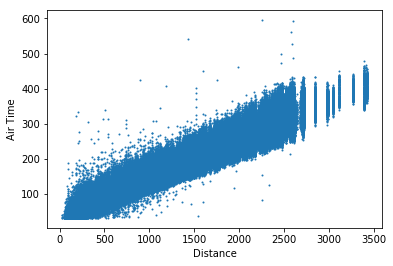

In [61]:
plt.scatter(data=df2, x="Distance", y="AirTime", alpha=1, s=1)
plt.xlabel("Distance")
plt.ylabel("Air Time");

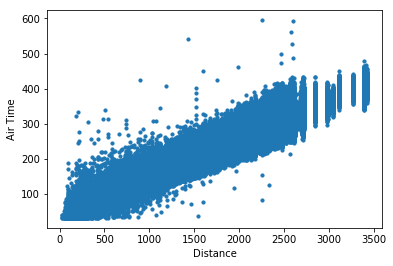

In [45]:
df2 = df2[(df2.Distance<3000) & (df2.AirTime>600) < 1]
plt.scatter(data=df2, x="Distance", y="AirTime", alpha=1, s=10)
plt.xlabel("Distance")
plt.ylabel("Air Time");

### Distance vs. ArrDelay

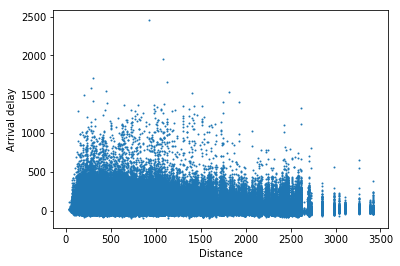

In [46]:
plt.scatter(data=df2, x="Distance", y="ArrDelay", s=1)
plt.xlabel("Distance")
plt.ylabel("Arrival delay");

 Now I will break this delay into departure time delay and elapsed time delay.

### Distance vs. DepDelay

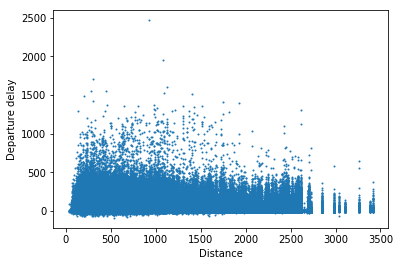

In [47]:
plt.scatter(data=df2, x="Distance", y="DepDelay", s=1)
plt.xlabel("Distance")
plt.ylabel("Departure delay");

This plot suggests that departure time 

### Distance vs. ElapsedTimeDelay

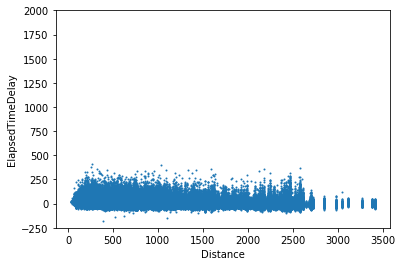

In [48]:
plt.scatter(data=df2, x="Distance", y="delay_elapsed", s=1)
plt.xlabel("Distance")
plt.ylabel("ElapsedTimeDelay")
plt.ylim([-250,2000]);

### ArrTime vs. Each-5DelayFactors
> In this section, I just investigate how ***qualitatively*** 5 Factors have influence on DepDelay, beacause I am sure that distance also has to be considered when thinking of these relationship. That is, I just want to clarify whether each factor is associated with Departure Delay or Elapsed Time Delay or maybe both of them. 

In [49]:
# make dummy series which has 4 columns, delay type, delay time, DepDelay, delay_elapsed
dummy = pd.DataFrame()
delay_types = ["NASDelay","LateAircraftDelay","CarrierDelay","WeatherDelay"]

for type in delay_types:
    dum = pd.DataFrame()
    dum["time"] = df2[df2[type] != 0][type]
    dum["DepDelay"] = df2[df2[type] != 0]["DepDelay"]
    dum["delay_elapsed"] = df2[df2[type] != 0]["delay_elapsed"]
    dum["ArrDelay"] = df2[df2[type] != 0]["ArrDelay"]
    dum["Distance"] = df2[df2[type] != 0]["Distance"]
    dum["type"] = type
    dummy = dummy.append(dum)

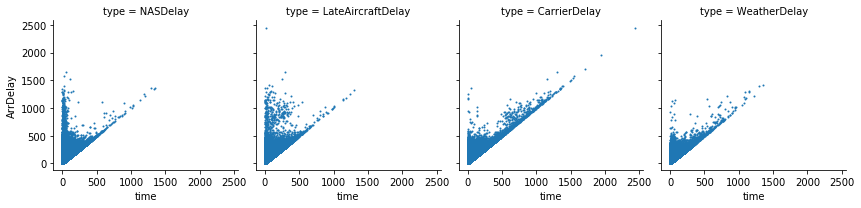

In [50]:
g = sb.FacetGrid(data=dummy, col="type")
g.map(plt.scatter, "time", "ArrDelay", s=1);

### DepTime vs. Each-4DelayFactors


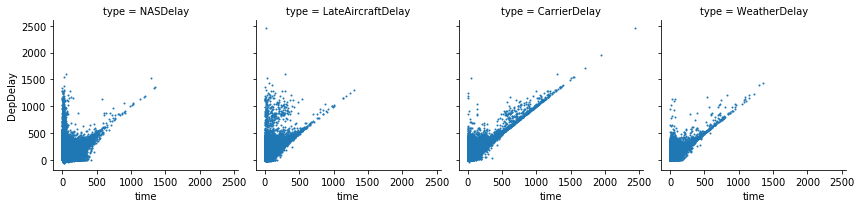

In [51]:
g = sb.FacetGrid(data=dummy, col="type")
g.map(plt.scatter, "time", "DepDelay", s=1);

> all of 5 delay types can hold up the departure.

### ElapsedTimeDelay vs. Each-5DelayFactors

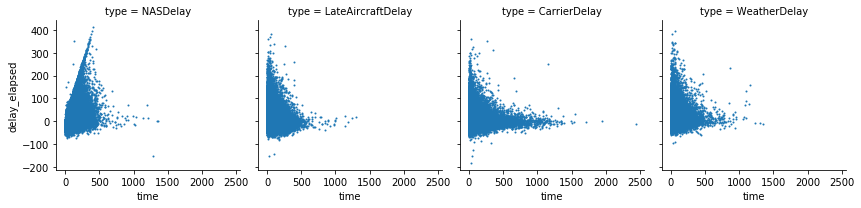

In [52]:
g = sb.FacetGrid(data=dummy, col="type")
g.map(plt.scatter, "time", "delay_elapsed", s=1);

> Only NAS delay has a different feature from other types of delay. Though these grahs besides NASdelay sugggests that these types of delay don't prolong the elapsed time substantially in airplane, NAS delay does. It is counterintuitive for me because I think that weather delay seems to have the strong effect on the time in the sky. ***I would investigate this NSA Delay's feature in the multivariate-part linked with the flight distance.***

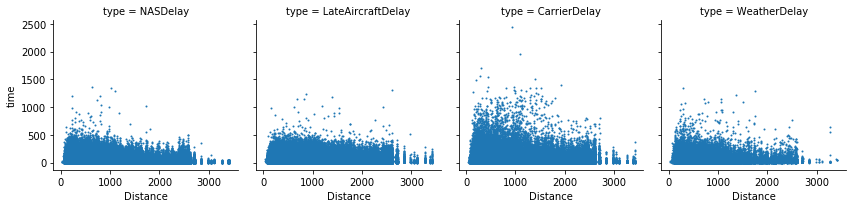

In [53]:
g = sb.FacetGrid(data=dummy, col="type")
g.map(plt.scatter, "Distance", "time", s=1);

> Compared with dearture delay, 5 delay factors in the dataset does not strongly lead Elapsed time Delay. However, some of short CarrierDelay prolong ElapsedTime.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

In [54]:
df3 = df2.copy()

### DIstance vs. DepDelay vs. ElapsedTimeDelay 

In [55]:
# make dummy series which has 5 columns, delay type, delay time, DepDelay, delay_elapsed, distance

dummy = pd.DataFrame()
delay_types = ["NASDelay","LateAircraftDelay","CarrierDelay","WeatherDelay"]

for type in delay_types:
    dum = pd.DataFrame()
    dum["time"] = df3[df3[type] != 0][type]
    dum["DepDelay"] = df3[df3[type] != 0]["DepDelay"]
    dum["delay_elapsed"] = df3[df3[type] != 0]["delay_elapsed"]
    dum["ArrDelay"] = df3[df3[type] != 0]["ArrDelay"]
    dum["Distance"] = df3[df3[type] != 0]["Distance"]
    dum["type"] = type
    dummy = dummy.append(dum)

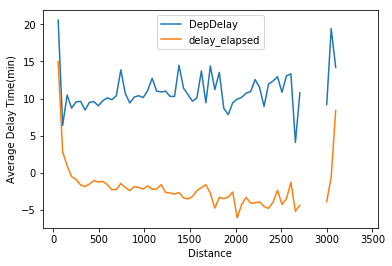

In [56]:
for de in ["DepDelay","delay_elapsed"]:
    bin_edges = np.linspace(df3.Distance.min(), df3.Distance.max(), 70)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    data_bins = pd.cut(df3.Distance, bin_edges, right = False, include_lowest=True)
    means = df3[de].groupby(data_bins).mean()
    plt.errorbar(x=bin_centers,y=means)
plt.xlabel("Distance")
plt.ylabel("Average Delay Time(min)")
plt.legend();

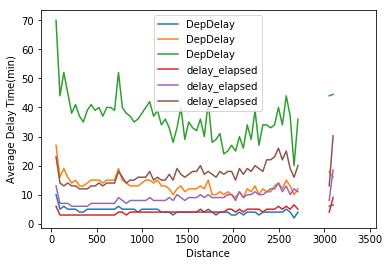

In [57]:
df3_delay = df3[df3.delay_elapsed > 0]

for de in ["DepDelay","delay_elapsed"]:
    df3_delay = df3[df3[de] > 0]
    bin_edges = np.linspace(df3_delay.Distance.min(), df3_delay.Distance.max(), 80)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    data_bins = pd.cut(df3_delay.Distance, bin_edges, right = False, include_lowest=True)
    q1 = df3_delay[de].groupby(data_bins).quantile(.25)
    m2 = df3_delay[de].groupby(data_bins).median()
    q3 = df3_delay[de].groupby(data_bins).quantile(.75)
    plt.errorbar(x=bin_centers,y=q1)
    plt.errorbar(x=bin_centers,y=m2)
    plt.errorbar(x=bin_centers,y=q3)
plt.xlabel("Distance")
plt.ylabel("Average Delay Time(min)")
plt.legend();

> Delay of departure time tenda to be longer and more effects arrival time delay rather than Elapsed Time Delay.

### Distance vs. DepDelay vs. Each-5DelayFactors

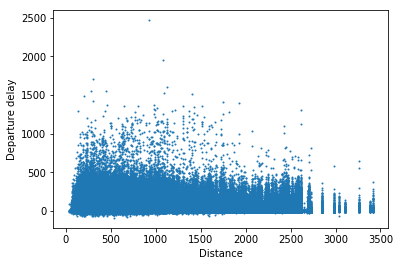

In [58]:
plt.scatter(data=df3, x="Distance", y="DepDelay", s=1)
plt.xlabel("Distance")
plt.ylabel("Departure delay");

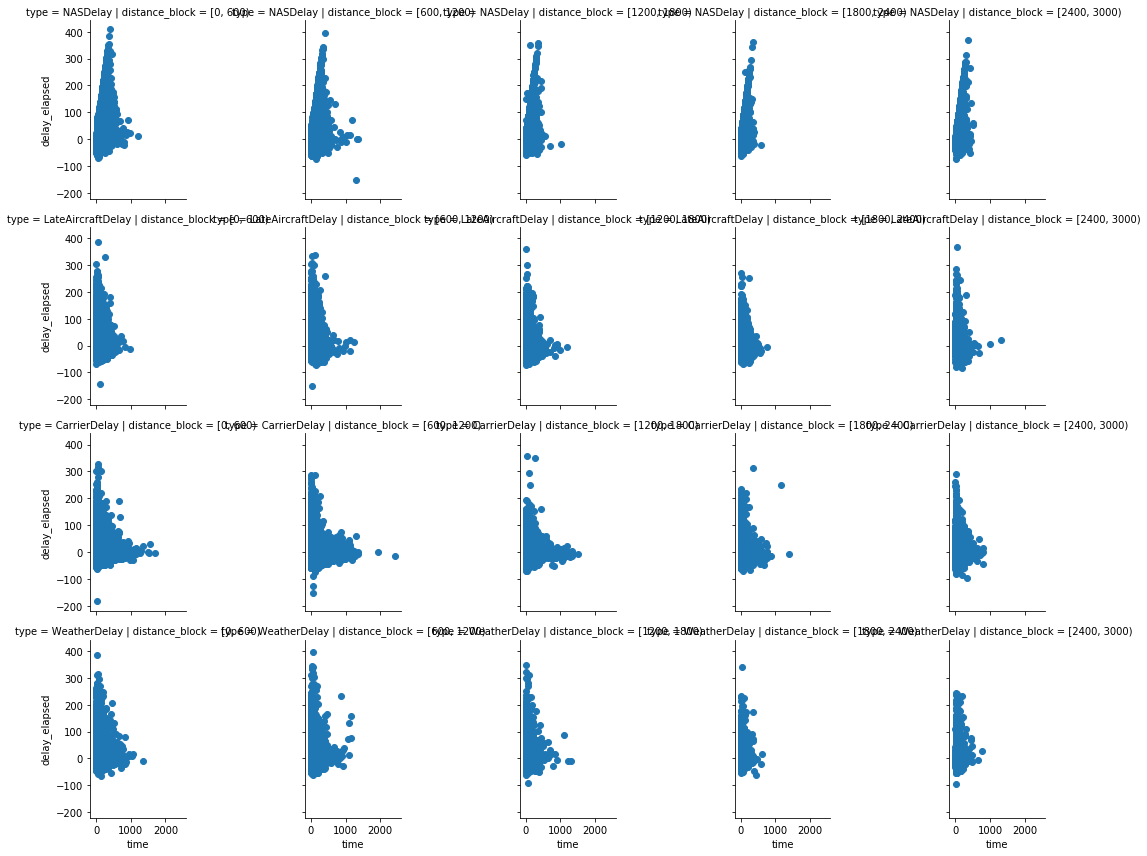

In [59]:
bin_edges = np.arange(0,3600,600)
dummy["distance_block"] = pd.cut(dummy.Distance, bin_edges, right=False, include_lowest=True)
g = sb.FacetGrid(data=dummy, col="distance_block", row="type" )
g.map(plt.scatter, "time", "delay_elapsed")

#for i in range(6):
#    g.map(dummy_block)

#df3_2 = df3[(600 <= df3.Distance) & (df3.Distance < 1200)]
#df3_3 = df3[(600 <= df3.Distance) & (df3.Distance < 1200)]

In [60]:
plt.scatter(data=df_dis1000, x="NASDelay", y="DepDelay")

NameError: name 'df_dis1000' is not defined

In [ ]:

g = sb.FacetGrid(data=dummy, row="type", hue="Distance")
g.map(plt.scatter, "time", "DepDelay")
plt.colorbar();


In [ ]:
pd.cut(df3.Distance, bin_edges, right = False, include_lowest=True)

###  Distance vs. ElapsedTimeDelay vs. Each-5DelayFactors

In [ ]:
g = sb.FacetGrid(data=dummy, col="type")
g.map(plt.scatter, "time", "delay_elapsed", "Distance")
#plt.colorbar();

In [ ]:
df[df.CarrierDelay

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!

In [ ]:
# The mean delay time of each type of delay 
p_car = df[df.CarrierDelay != 0].CarrierDelay.median() #/ df.shape[0]
p_wea = df[df.WeatherDelay != 0].WeatherDelay.median()
p_nas = df[df.NASDelay != 0].NASDelay.median()  #sum() / df.shape[0]
p_sec = df[df.SecurityDelay != 0].SecurityDelay.median()   #sum() / df.shape[0]
p_airc = df[df.LateAircraftDelay != 0].LateAircraftDelay.median() #sum() / df.shape[0]

delay_types = pd.Series([p_car,p_wea,p_nas,p_sec,p_airc], index=["car","wea","nas","sec","airc"]).sort_values(ascending=False)
sb.barplot(delay_types.index, delay_types, color=sb.color_palette()[0]);